In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from sklearn.preprocessing import StandardScaler


In [4]:
df_hh_train=pd.read_csv('HH_Train_Data.csv')
df_pp_train=pd.read_csv('Person_Train_Data.csv')
df_hh_test=pd.read_csv('HH_Test_Data.csv')
df_pp_test=pd.read_csv('Person_Test_Data.csv')

# Count missing values per column
missing_values = df_hh_train.isnull().sum()
print(missing_values)


# max of NCO_3D and min of NIC_5D columns
print(df_hh_train['NCO_3D'].max())
print(df_hh_train['NIC_5D'].min())




HH_ID                                                    0
Sector                                                   0
State                                                    0
NSS-Region                                               0
District                                                 0
Household Type                                           0
Religion of the head of the household                    0
Social Group of the head of the household                0
HH Size (For FDQ)                                        0
NCO_3D                                               19947
NIC_5D                                               19947
Is_online_Clothing_Purchased_Last365                167602
Is_online_Footwear_Purchased_Last365                181550
Is_online_Furniture_fixturesPurchased_Last365       208560
Is_online_Mobile_Handset_Purchased_Last365          205356
Is_online_Personal_Goods_Purchased_Last365          202783
Is_online_Recreation_Goods_Purchased_Last365        2076

In [5]:
# fill missing values of NCO_3D with 962.0 and NIC_5D with 1110.0
df_hh_train['NCO_3D'].fillna(963, inplace=True)
df_hh_test['NCO_3D'].fillna(963, inplace=True)
df_hh_train['NIC_5D'].fillna(1110, inplace=True)
df_hh_test['NIC_5D'].fillna(1110, inplace=True)

df_hh_train.fillna(0, inplace=True)
df_pp_train.fillna(0, inplace=True)
df_hh_test.fillna(0, inplace=True)
df_pp_test.fillna(0, inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_11288\1814960414.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hh_train['NCO_3D'].fillna(963, inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_11288\1814960414.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [6]:
def compute_features(group):
    # Count of adults: Age 18-64 (inclusive)
    count_adults = group[(group['Age(in years)'] >= 18) & (group['Age(in years)'] <= 64)].shape[0]
    adults_mean_age = group[(group['Age(in years)'] >= 18) & (group['Age(in years)'] <= 64)]['Age(in years)'].mean() 

    
    # Count of children: Age below 18
    count_children = group[group['Age(in years)'] < 18].shape[0]
    children_mean_age = group[group['Age(in years)'] < 18]['Age(in years)'].mean()
    
    # Count of elders: Age 65 and above
    count_elders = group[group['Age(in years)'] >= 65].shape[0]
    elders_mean_age = group[group['Age(in years)'] >= 65]['Age(in years)'].mean()
    
    # Gender ratio: Count females divided by count males
    # Adjust the gender codes if needed. Here we assume: 1=Male, 2=Female.
    count_males = group[group['Gender'] == 1].shape[0]
    count_females = group[group['Gender'] == 2].shape[0]
    gender_ratio = count_females / (count_males + 1) # Add 1 to avoid division by zero
    
    # Mean age
    mean_age = group['Age(in years)'].mean()
    
    # Dependency ratio: (Count of children + Count of elders) / Count of adults
    dependency_ratio = (count_children + count_elders) / (count_adults + 1) # Add 1 to avoid division by zero
    
    # Count of married: assuming Marital Status code 2 means currently married
    count_married = group[group['Marital Status (code)'] == 2].shape[0]
    
    # Maximum educational level attained (assuming higher code means higher education)
    max_education = group['Highest educational level attained (code)'].max()
    
    # Count of internet users: assuming '1' indicates "Yes"
    count_internet_users = group[group['Whether used internet from any location during last 30 days'] == 1].shape[0]
    
    # Total meals from various sources. Check if column exists before summing.
    total_meals_school = group['No. of meals taken during last 30 days from school, balwadi etc.'].sum() if 'No. of meals taken during last 30 days from school, balwadi etc.' in group.columns else np.nan
    total_meals_employer = group['No. of meals taken during last 30 days from employer as perquisites or part of wage'].sum() if 'No. of meals taken during last 30 days from employer as perquisites or part of wage' in group.columns else np.nan
    total_meals_payment = group['No. of meals taken during last 30 days on payment'].sum() if 'No. of meals taken during last 30 days on payment' in group.columns else np.nan
    total_meals_home = group['No. of meals taken during last 30 days at home'].sum() if 'No. of meals taken during last 30 days at home' in group.columns else np.nan
    total_meals_others = group['No. of meals taken during last 30 days  others'].sum() if 'No. of meals taken during last 30 days  others' in group.columns else np.nan
    
    return pd.Series({
        'count_adults': count_adults,
        'adults_mean_age': adults_mean_age,
        'count_children': count_children,
        'children_mean_age': children_mean_age,
        'count_elders': count_elders,
        'elders_mean_age': elders_mean_age,
        'count_males': count_males,
        'count_females': count_females,
        'gender_ratio': gender_ratio,
        'mean_age': mean_age,
        'dependency_ratio': dependency_ratio,
        'count_married': count_married,
        'max_education': max_education,
        'count_internet_users': count_internet_users,
        'total_meals_school': total_meals_school,
        'total_meals_employer': total_meals_employer,
        'total_meals_payment': total_meals_payment,
        'total_meals_home': total_meals_home,
        'total_meals_others': total_meals_others,
    })




In [7]:
# Group the person-level dataset by HH_ID and compute the aggregated features.
person_features = df_pp_train.groupby('HH_ID').apply(compute_features).reset_index()

# Merge the computed features into the household dataset using HH_ID.
master_df = pd.merge(df_hh_train, person_features, on='HH_ID', how='left')

# fill missing values of person features with 0
master_df.fillna(0, inplace=True)

# Optional: Save the master dataset to a new CSV file.
master_df.to_csv("aggregated_data_train.csv", index=False)

print("Master train dataset created successfully!")

C:\Users\Asus\AppData\Local\Temp\ipykernel_11288\2149584323.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  person_features = df_pp_train.groupby('HH_ID').apply(compute_features).reset_index()


Master train dataset created successfully!


In [8]:
# Group the person-level dataset by HH_ID and compute the aggregated features.
person_features = df_pp_test.groupby('HH_ID').apply(compute_features).reset_index()

# Merge the computed features into the household dataset using HH_ID.
master_df = pd.merge(df_hh_test, person_features, on='HH_ID', how='left')

# fill missing values of person features with 0
master_df.fillna(0, inplace=True)

# Optional: Save the master dataset to a new CSV file.
master_df.to_csv("aggregated_data_test.csv", index=False)

print("Master test dataset created successfully!")


C:\Users\Asus\AppData\Local\Temp\ipykernel_11288\1037419563.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  person_features = df_pp_test.groupby('HH_ID').apply(compute_features).reset_index()


Master test dataset created successfully!


In [9]:
# Load the data
train_data = pd.read_csv('aggregated_data_train.csv')
test_data = pd.read_csv('aggregated_data_test.csv')

# Drop the first column
train_data = train_data.drop(columns=['HH_ID'])
test_data = test_data.drop(columns=['HH_ID'])

# Display basic information
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Display first few rows of training data
train_data.head()

Training data shape: (209396, 53)
Test data shape: (52350, 53)


,Sector,State,NSS-Region,District,Household Type,Religion of the head of the household,Social Group of the head of the household,HH Size (For FDQ),NCO_3D,NIC_5D,...,mean_age,dependency_ratio,count_married,max_education,count_internet_users,total_meals_school,total_meals_employer,total_meals_payment,total_meals_home,total_meals_others
0,1,21,213,6,6,1,1,2,931.0,41001.0,...,55.000000,0.00,2.0,4.0,0.0,0.0,0.0,0.0,180.0,0.0
1,2,19,193,11,1,1,9,1,522.0,56101.0,...,46.000000,0.00,0.0,5.0,0.0,0.0,0.0,0.0,60.0,0.0
2,2,15,151,3,2,3,1,5,411.0,84119.0,...,29.600000,0.20,2.0,12.0,5.0,0.0,0.0,42.0,408.0,0.0
3,1,12,121,9,1,6,9,6,611.0,1252.0,...,24.166667,0.75,2.0,6.0,4.0,40.0,0.0,0.0,500.0,0.0
4,2,29,293,18,9,1,3,2,963.0,1110.0,...,61.500000,0.00,2.0,7.0,1.0,0.0,0.0,6.0,174.0,0.0


In [10]:
# Separate features and target variable
X_train = train_data.drop(['TotalExpense'], axis=1)
y_train = train_data['TotalExpense']

X_test = test_data.drop(['TotalExpense'], axis=1)
y_test = test_data['TotalExpense']

# apply log transformation to target variable
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Check if there are any missing values
print("Missing values in training features:", X_train.isnull().sum().sum())
print("Missing values in test features:", X_test.isnull().sum().sum())

# Create LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train_log)
test_dataset = lgb.Dataset(X_test, label=y_test_log, reference=train_dataset)

Missing values in training features: 0
Missing values in test features: 0


In [11]:
# Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 500,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 1
}

# Train the model
print("Training LightGBM model...")
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=5000,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# Make predictions with time
import time
start = time.time()
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_train = np.expm1(y_pred_train)
end = time.time()
print("Time taken to make predictions on training data:", end-start)

# Make predictions on test data
start = time.time()
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_test = np.expm1(y_pred_test)
end = time.time()
print("Time taken to make predictions on test data:", end-start)


Training LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2418
[LightGBM] [Info] Number of data points in the train set: 209396, number of used features: 52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.764839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1321]	training's rmse: 0.205949	valid_1's rmse: 0.29867


In [12]:
# Evaluate the model
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"Evaluation on {dataset_name} dataset:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

# Evaluate on training and test sets
train_metrics = evaluate_model(y_train, y_pred_train, "Training")
test_metrics = evaluate_model(y_test, y_pred_test, "Test")

Evaluation on Training dataset:
MAE: 3250.7438
RMSE: 6497.9291
R²: 0.7794
MAPE: 0.1574
Evaluation on Test dataset:
MAE: 4732.6551
RMSE: 8685.9161
R²: 0.5947
MAPE: 0.2307


In [ ]:
# Save the model
model_filename = "model.pkl"
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)

print("Model saved to:", model_filename)

<Figure size 1200x800 with 0 Axes>

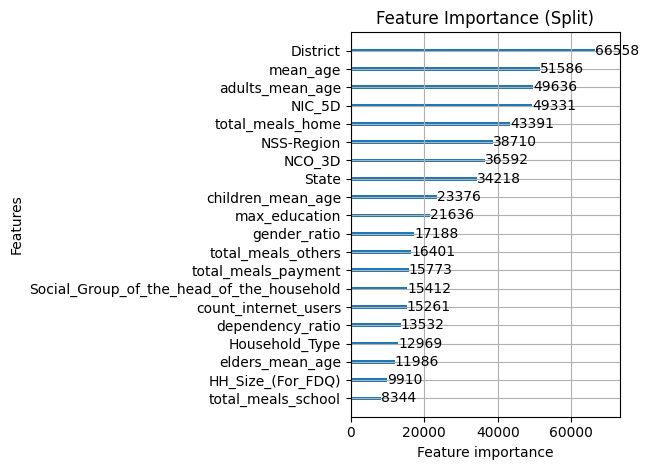

<Figure size 1200x800 with 0 Axes>

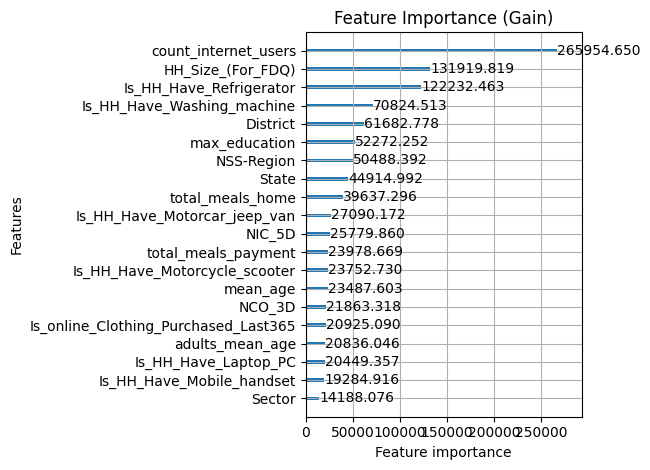

In [13]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=20, importance_type='split')
plt.title('Feature Importance (Split)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.tight_layout()
plt.show()

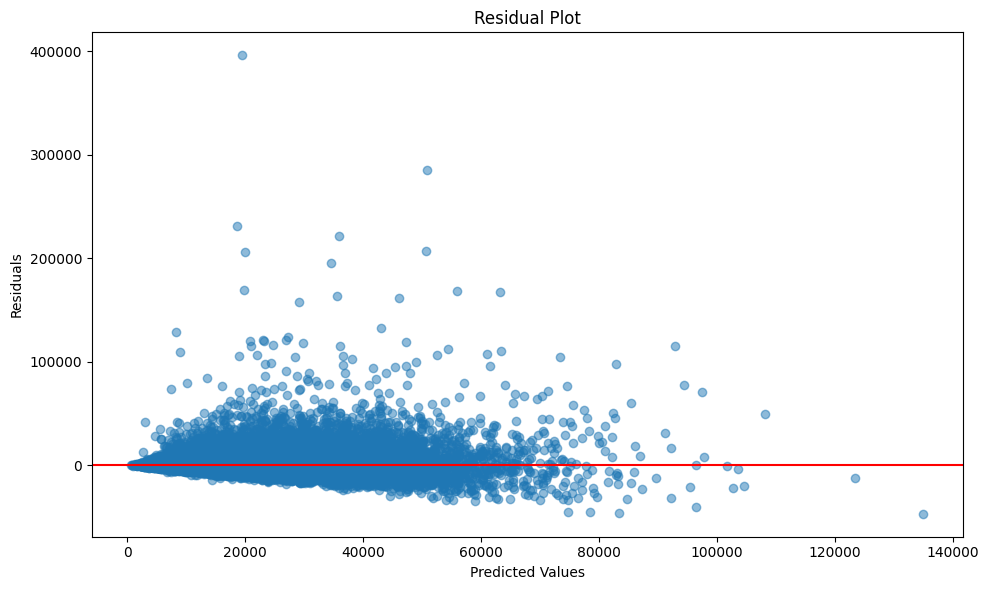

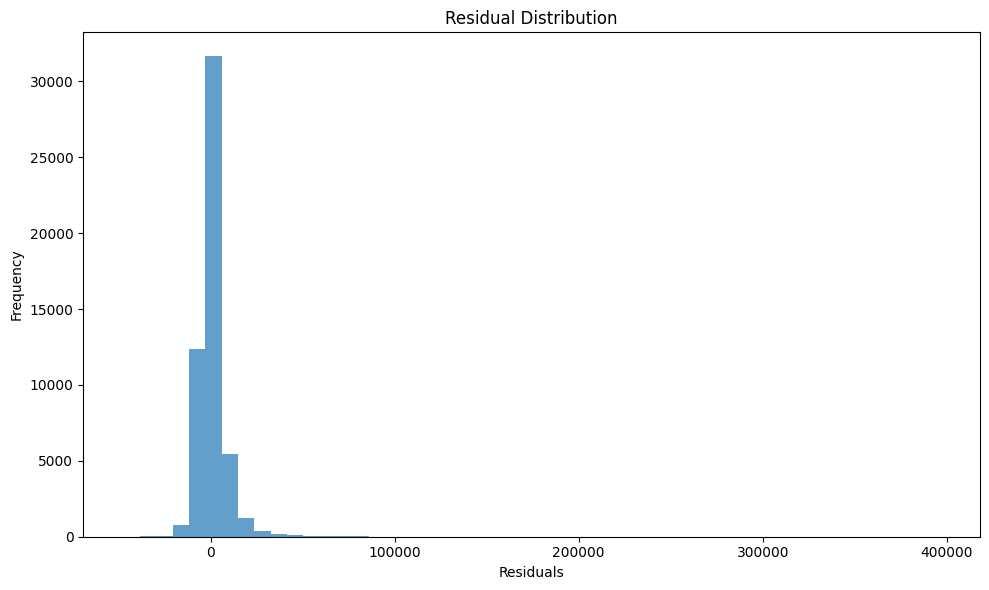

In [14]:
# Analyze residuals
residuals_test = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=50, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

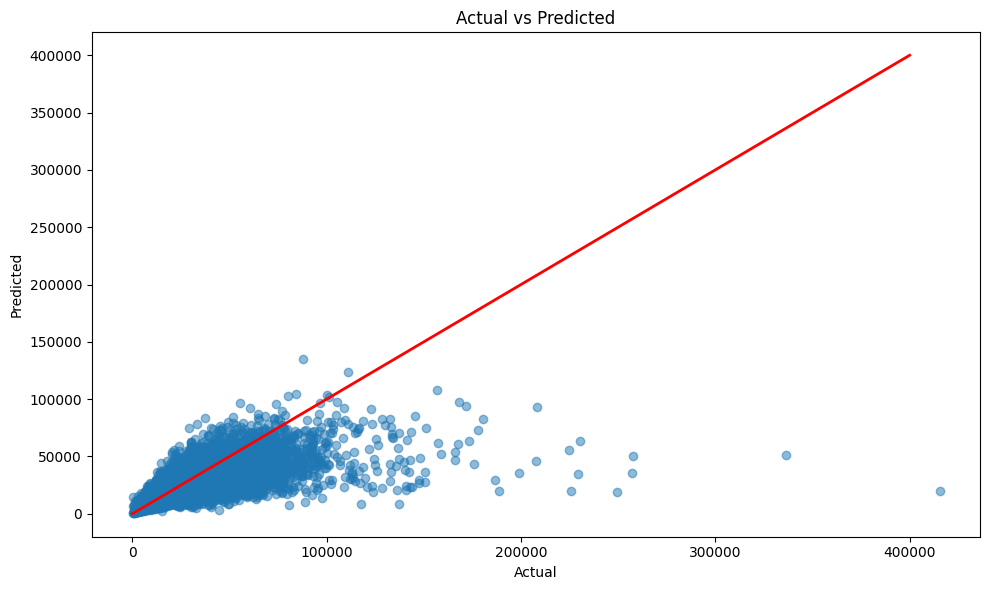

In [15]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([0, 400000], [0, 400000], color='red', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()

In [ ]:
def mpce_predict(hh_data_df, pp_data_df):
    hh_data_df['NCO_3D'].fillna(963, inplace=True)
    hh_data_df['NIC_5D'].fillna(1110, inplace=True)

    hh_data_df.fillna(0, inplace=True)
    pp_data_df.fillna(0, inplace=True)

    # Group the person-level dataset by HH_ID and compute the aggregated features.
    person_features = pp_data_df.groupby('HH_ID').apply(compute_features).reset_index()

    # Merge the computed features into the household dataset using HH_ID.
    master_df = pd.merge(hh_data_df, person_features, on='HH_ID', how='left')

    # fill missing values of person features with 0
    master_df.fillna(0, inplace=True)

    # Optional: Save the master dataset to a new CSV file.
    # master_df.to_csv("aggregated_data_test.csv", index=False)
    
    # Drop the first column
    master_df = master_df.drop(columns=['HH_ID'])

    # if master data contains TotalExpense column, drop it
    if 'TotalExpense' in master_df.columns:
        master_df = master_df.drop(columns=['TotalExpense'])
    
    # Make predictions
    y_pred = model.predict(master_df, num_iteration=model.best_iteration)
    y_pred = np.expm1(y_pred)

    return y_pred

    
